In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import implicit

In [2]:
from implicit.datasets.movielens import get_movielens
from implicit.evaluation import leave_k_out_split

### CV

In [3]:
variant = "1m"

In [4]:
titles, ratings = get_movielens(variant)
ratings = ratings.T

In [7]:
col_names = ["user_id", "movie_id", "rating", "matrix_position"]
ratings_df = pd.read_csv('./ml-1m/ratings.dat', delimiter='::', names=col_names, engine='python')

In [72]:
ratings_df.groupby('user_id').movie_id.nunique()

user_id
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Name: movie_id, Length: 6040, dtype: int64

In [90]:
labels = list(range(1, 8))
popularity_cut = pd.qcut(ratings_df.groupby('user_id').movie_id.nunique(), 7)
popularity_cut.cat.rename_categories(labels, inplace=True)
popularity_cut = pd.DataFrame(popularity_cut)
popularity_cut = popularity_cut.reset_index(drop=False)
popularity_cut.columns = ['user_id', 'usage']
popularity_cut

/var/folders/tc/kb5gq8ms7xv2tdf3j0y_5yzh0000gn/T/ipykernel_17928/643428778.py:3: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  popularity_cut.cat.rename_categories(labels, inplace=True)


,user_id,usage
0,1,3
1,2,5
2,3,3
3,4,1
4,5,6
...,...,...
6035,6036,7
6036,6037,6
6037,6038,1
6038,6039,5


In [97]:
popularity_cut_counts = pd.DataFrame(popularity_cut.groupby('usage').count())
popularity_cut_counts = popularity_cut_counts.reset_index(drop=False)

,usage,user_id
0,1,915
1,2,828
2,3,861
3,4,859
4,5,852
5,6,865
6,7,860


In [5]:
def get_divided_test_fold(ratings_df, test_index, sampling_rate=.2):
    test_fold_df = ratings_df[ratings_df.user_id.isin(test_index)].copy()
    test_df = test_fold_df.groupby('user_id').sample(frac=.2)
    test_fold_df.loc[test_fold_df.matrix_position.isin(test_df.matrix_position), 'rating'] = 0
    
    return test_fold_df, test_df

In [123]:
ratings_df

,user_id,movie_id,rating,matrix_position
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [52]:
ndcg_dict_age = {}
for a in users_reduced.age.unique():
    ndcg_dict_age[a] = []

ndcg_dict_gender = {}
for g in users_reduced.gender.unique():
    ndcg_dict_gender[g] = []

ndcg_dict_usage = {}
for g in range(1, 8):
    ndcg_dict_usage[g] = []

In [91]:
# divide ratings into 5 CV
# 0th column is 0, since user ids start with 1
from sklearn.model_selection import KFold
from implicit.evaluation import ndcg_at_k
from implicit.als import AlternatingLeastSquares

kf = KFold(n_splits=5, random_state=12345, shuffle=True)

for i, (train_index, test_index) in enumerate(kf.split(ratings)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index.shape}")
    print(f"  Test:  index={test_index.shape}")
    
    # train data is divided into two parts
    # in train_index, full user data is used for training
    # in test_index, 80% of user data is used for training and the rest 20% is used for testing
    test_train_df, test_test_df = get_divided_test_fold(ratings_df, test_index)

    train_data = ratings.copy()
    # blend out the 20% of test users data for testing
    train_data[test_test_df.user_id, test_test_df.movie_id] = 0

    # test data contains data used for training + 20% blended in train data
    # test_data = ratings[test_index,]

    model = AlternatingLeastSquares(factors=50, regularization=0.01)
    model.fit(train_data)

    test_test_df = test_test_df.merge(users_reduced, how='left', on='user_id')
    test_test_df = test_test_df.merge(popularity_cut, how='left', on='user_id')

    # for a in users_reduced.age.unique():
    #     test_data = ratings[test_test_df[test_test_df.age == a].user_id.unique()]
    #     ndcg_dict_age[a].append(ndcg_at_k(model, train_data, test_data, K=10))

    # for g in users_reduced.gender.unique():
    #     test_data = ratings[test_test_df[test_test_df.gender == g].user_id.unique()]
    #     ndcg_dict_gender[g].append(ndcg_at_k(model, train_data, test_data, K=10))

    for g in range(1, 8):
        test_data = ratings[test_test_df[test_test_df.usage == g].user_id.unique()]
        ndcg_dict_usage[g].append(ndcg_at_k(model, train_data, test_data, K=10))

    # ndcg = ndcg_at_k(model, train_data, test_data, K=10)
    # print(f'ndcg: {ndcg}')




Fold 0:
  Train: index=(4832,)
  Test:  index=(1209,)


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

Fold 1:
  Train: index=(4833,)
  Test:  index=(1208,)


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Fold 2:
  Train: index=(4833,)
  Test:  index=(1208,)


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Fold 3:
  Train: index=(4833,)
  Test:  index=(1208,)


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

Fold 4:
  Train: index=(4833,)
  Test:  index=(1208,)


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

In [122]:
ndcg_dict_age

{1: [0.15380258466102842,
  0.2072596099210468,
  0.18594233470577334,
  0.18096749907453802,
  0.2431262387432107],
 56: [0.1321470627605913,
  0.13490025899757124,
  0.14375697931640335,
  0.10414046384655128,
  0.19905685793925623],
 25: [0.2601875014391819,
  0.27913542950378356,
  0.2718297913508741,
  0.2535803955152815,
  0.2779942046778636],
 45: [0.19847964943257262,
  0.20087776927064188,
  0.17849244164921607,
  0.24295278670376574,
  0.2386205692245304],
 50: [0.1859684331250786,
  0.14914221277402406,
  0.1953803519937174,
  0.23165901934003852,
  0.23251831845902798],
 35: [0.2175680591541483,
  0.2230571368707836,
  0.2181128134629776,
  0.26028513864251057,
  0.23005872481717643],
 18: [0.26965477412154815,
  0.23677332457729147,
  0.26539902718217073,
  0.2395874943317941,
  0.2086602061162775]}

In [109]:
from scipy import stats

In [105]:
df_ndcg_age = pd.DataFrame(ndcg_dict_age)
df_ndcg_age = pd.DataFrame(df_ndcg_age.mean())
df_ndcg_age = df_ndcg_age.reset_index(drop=False)
df_ndcg_age.columns = ['age', 'ndcg']
df_ndcg_age

,1,56,25,45,50,35,18
0,0.153803,0.132147,0.260188,0.198480,0.185968,0.217568,0.269655
1,0.207260,0.134900,0.279135,0.200878,0.149142,0.223057,0.236773
2,0.185942,0.143757,0.271830,0.178492,0.195380,0.218113,0.265399
3,0.180967,0.104140,0.253580,0.242953,0.231659,0.260285,0.239587
4,0.243126,0.199057,0.277994,0.238621,0.232518,0.230059,0.208660


In [124]:
age_list = list(ndcg_dict_age.values())
# stats.kruskal(age_list[0], age_list[1], age_list[2], age_list[3], age_list[4], age_list[5],age_list[6])
stats.kruskal(*age_list)

KruskalResult(statistic=22.723809523809535, pvalue=0.0008944599961842898)

In [56]:
df_ndcg_gender = pd.DataFrame(ndcg_dict_gender)
df_ndcg_gender = pd.DataFrame(df_ndcg_gender.mean())
df_ndcg_gender = df_ndcg_gender.reset_index(drop=False)
df_ndcg_gender.columns = ['age', 'ndcg']

In [120]:
gender_list = list(ndcg_dict_gender.values())
stats.kruskal(gender_list[0], gender_list[1])

KruskalResult(statistic=6.818181818181813, pvalue=0.009023438818080334)

In [93]:
df_ndcg_usage = pd.DataFrame(ndcg_dict_usage)
df_ndcg_usage = pd.DataFrame(df_ndcg_usage.mean())
df_ndcg_usage = df_ndcg_usage.reset_index(drop=False)
df_ndcg_usage.columns = ['age', 'ndcg']

In [121]:
usage_list = list(ndcg_dict_usage.values())
stats.kruskal(usage_list[0], usage_list[1], usage_list[2], usage_list[3], usage_list[4], usage_list[5],usage_list[6])

KruskalResult(statistic=33.33333333333334, pvalue=9.045386293179479e-06)

In [48]:
df_ndcg_age

,age,ndcg
0,1,0.189213
1,56,0.142301
2,25,0.268928
3,45,0.209240
4,50,0.194821
5,35,0.231203
6,18,0.245899


<AxesSubplot: title={'center': 'Distribution of ndcg per gender'}, xlabel='age', ylabel='ndcg'>

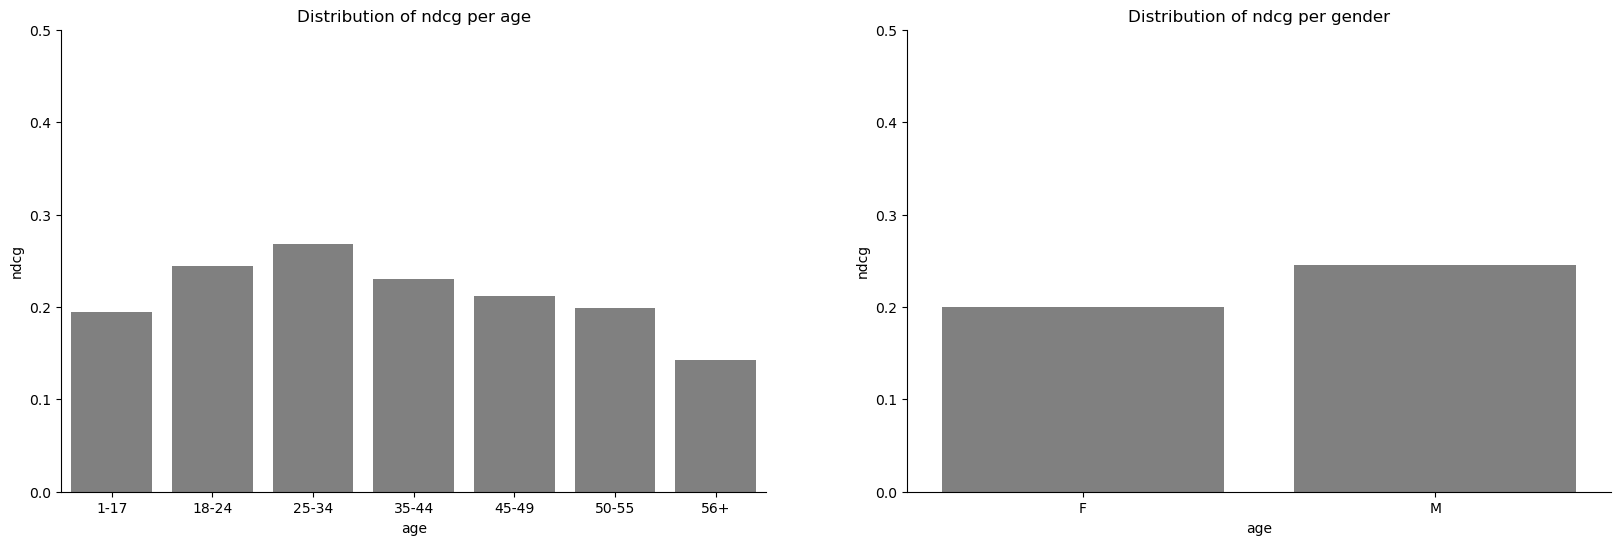

In [58]:
_, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.despine()

ax[0].set_title('Distribution of ndcg per age')
ax[0].set_ylim((0, 0.5))
sns.barplot(data=df_ndcg_age, x='age', y='ndcg', color='grey', ax=ax[0])
ax[0].set_xticks(list(range(0, len(age_bins))), labels=age_labels)

ax[1].set_title('Distribution of ndcg per gender')
ax[1].set_ylim((0, 0.5))
sns.barplot(data=df_ndcg_gender, x='age', y='ndcg', color='grey', ax=ax[1])

In [103]:
popularity_cut_counts['percentage'] = popularity_cut_counts.user_id / popularity_cut_counts.user_id.sum()

<AxesSubplot: title={'center': 'Distribution of ndcg per usage'}, xlabel='age', ylabel='ndcg'>

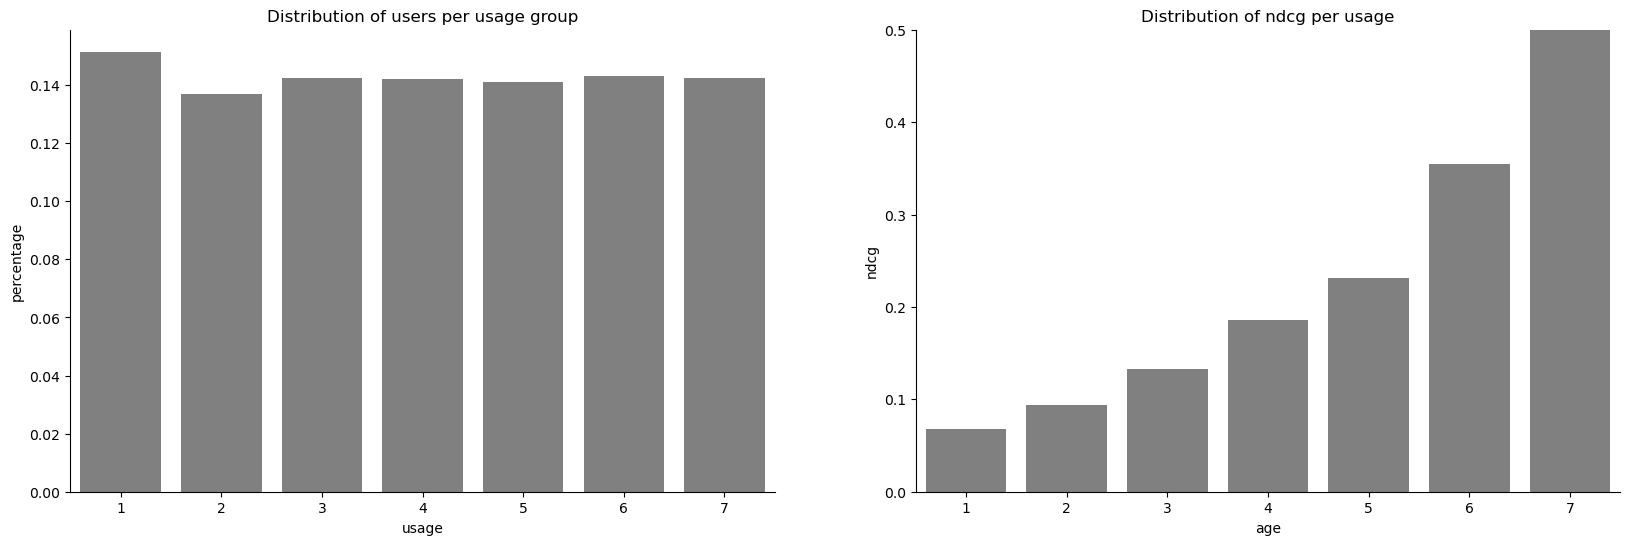

In [104]:
_, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.despine()

ax[0].set_title('Distribution of users per usage group')
sns.barplot(data=popularity_cut_counts, x='usage', y='percentage', color='grey', ax=ax[0], )

ax[1].set_title('Distribution of ndcg per usage')
ax[1].set_ylim((0, 0.5))
sns.barplot(data=df_ndcg_usage, x='age', y='ndcg', color='grey', ax=ax[1])

In [27]:
test_test_df

,user_id,movie_id,rating,matrix_position,gender,age
0,4,3468,5,978294008,M,45
1,4,3418,4,978294260,M,45
2,4,3702,4,978294260,M,45
3,4,1036,4,978294282,M,45
4,5,1429,3,978245829,M,25
...,...,...,...,...,...,...
41242,6029,3549,5,956721780,F,25
41243,6029,3546,5,956721930,F,25
41244,6029,3499,4,956721880,F,25
41245,6029,3552,2,956721732,F,25


In [30]:
ratings[test_test_df[test_test_df.age == 25].user_id.unique()]

<447x3953 sparse matrix of type '<class 'numpy.float32'>'
	with 86065 stored elements in Compressed Sparse Column format>

In [29]:
test_data

<1208x3953 sparse matrix of type '<class 'numpy.float32'>'
	with 206264 stored elements in Compressed Sparse Column format>

In [21]:
test_test_df

,user_id,movie_id,rating,matrix_position
233,4,3468,5,978294008
245,4,3418,4,978294260
246,4,3702,4,978294260
237,4,1036,4,978294282
354,5,1429,3,978245829
...,...,...,...,...
997989,6029,3549,5,956721780
997987,6029,3546,5,956721930
997977,6029,3499,4,956721880
997991,6029,3552,2,956721732


#### Blending data in test fold 

In [163]:
test_fold_df = ratings_df[ratings_df.user_id.isin(test_index)].copy()
test_df = test_fold_df.groupby('user_id').sample(frac=.2)
test_fold_df.loc[test_fold_df.matrix_position.isin(test_df.matrix_position), 'rating'] = 0

In [164]:
test_fold_df.loc[test_fold_df.matrix_position.isin(test_df.matrix_position), :]

,user_id,movie_id,rating,matrix_position
236,4,1214,0,978294260
238,4,260,0,978294199
239,4,2028,0,978294230
241,4,1196,0,978294199
242,4,1198,0,978294199
...,...,...,...,...
997991,6029,3552,0,956721732
997995,6029,3584,0,956721732
997997,6029,3591,0,956721880
997998,6029,1210,0,956721594


In [165]:
test_df

,user_id,movie_id,rating,matrix_position
250,4,1201,5,978294230
238,4,260,5,978294199
247,4,2366,4,978294230
236,4,1214,4,978294260
317,5,2282,3,978244667
...,...,...,...,...
997998,6029,1210,3,956721594
997987,6029,3546,5,956721930
997974,6029,2409,2,956721594
997995,6029,3584,3,956721732


## User binnings

#### Age and gender

In [10]:
col_names = ['user_id', 'gender', 'age', 'occupation', 'zip-code']
users = pd.read_csv('./ml-1m/users.dat', delimiter='::', names=col_names, engine='python')

In [12]:
users_reduced = users[['user_id', 'gender', 'age']].copy()
users_reduced

,user_id,gender,age
0,1,F,1
1,2,M,56
2,3,M,25
3,4,M,45
4,5,M,25
...,...,...,...
6035,6036,F,25
6036,6037,F,45
6037,6038,F,56
6038,6039,F,45


In [22]:
test_test_df = test_test_df.merge(users_reduced, how='left', on='user_id')

In [5]:
users.age.unique()

array([ 1, 56, 25, 45, 50, 35, 18])

In [39]:
age_bins = {}
age_bins[1] = '1-17'
age_bins[18] = '18-24'
age_bins[25] = '25-34'
age_bins[35] = '35-44'
age_bins[45] = '45-49'
age_bins[50] = '50-55'
age_bins[56] = '56+'

In [50]:
age_labels = list(age_bins.values())

<AxesSubplot: title={'center': 'Distribution of users per gender'}, xlabel='gender', ylabel='count'>

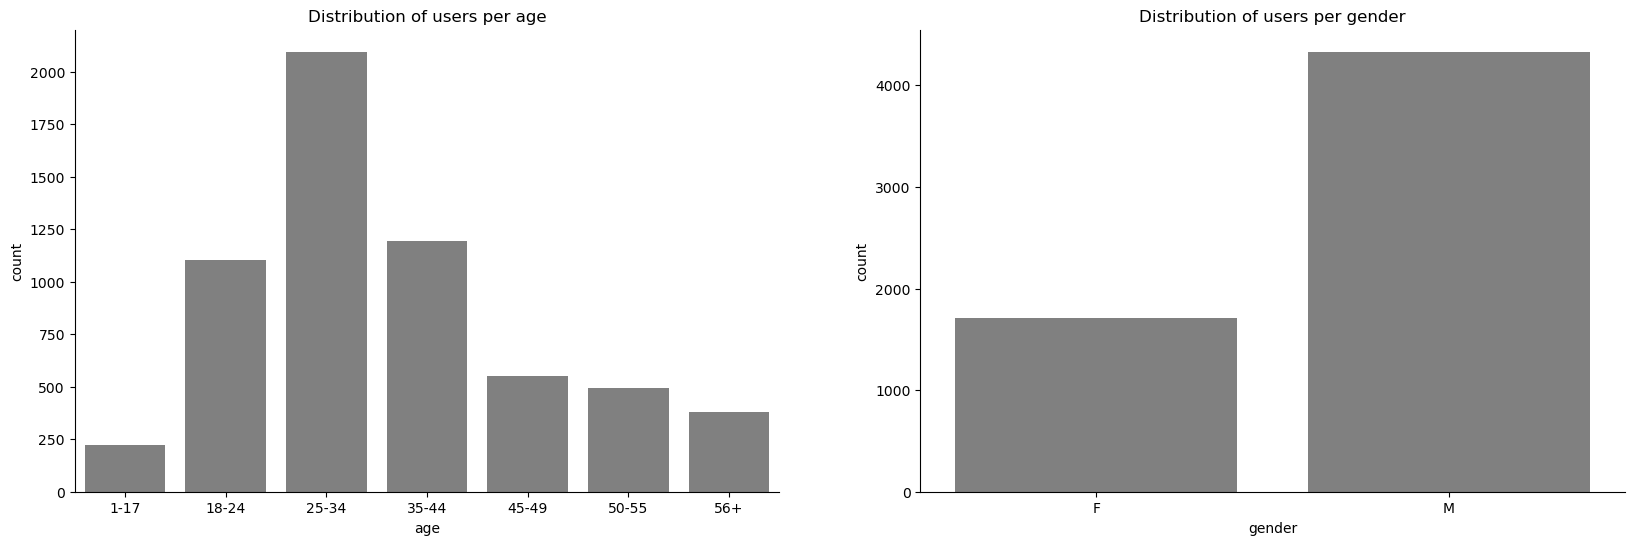

In [78]:
_, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.despine()

ax[0].set_title('Distribution of users per age')
sns.countplot(data=users, x='age', color='grey', ax=ax[0])
ax[0].set_xticks(list(range(0, len(age_bins))), labels=age_labels)

ax[1].set_title('Distribution of users per gender')
sns.countplot(data=users, x='gender', color='grey', ax=ax[1])

In [30]:
for age in age_bins.keys():
    print(f'{age_bins[age]} bin')
    users_curr_age = users[users.age == age].index.values
    ratings_curr_age = ratings[:, users_curr_age]
    
    print('ratings shape: ', ratings_curr_age.shape)

1-17 bin
ratings shape:  (3953, 222)
18-24 bin
ratings shape:  (3953, 1103)
25-34 bin
ratings shape:  (3953, 2096)
35-44 bin
ratings shape:  (3953, 1193)
45-49 bin
ratings shape:  (3953, 550)
50-55 bin
ratings shape:  (3953, 496)
56+ bin
ratings shape:  (3953, 380)


#### Usage and pop-index

In [98]:
ratings.data = np.ones(len(ratings.data))
usage_vals = np.array(ratings.sum(axis=0)).flatten()[1:]

In [102]:
users

,user_id,gender,age,occupation,zip-code,usage
0,1,F,1,10,48067,53.0
1,2,M,56,16,70072,129.0
2,3,M,25,15,55117,51.0
3,4,M,45,7,02460,21.0
4,5,M,25,20,55455,198.0
...,...,...,...,...,...,...
6035,6036,F,25,15,32603,888.0
6036,6037,F,45,1,76006,202.0
6037,6038,F,56,1,14706,20.0
6038,6039,F,45,0,01060,123.0


In [99]:
usage_vals

array([ 53., 129.,  51., ...,  20., 123., 341.])

In [101]:
users['usage'] = usage_vals

<AxesSubplot: xlabel='usage', ylabel='Count'>

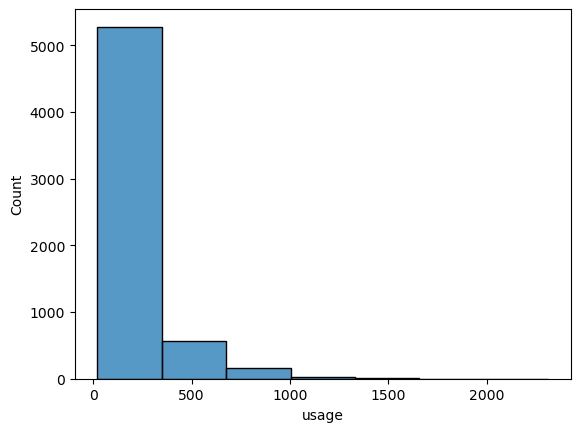

In [105]:
sns.histplot(users, x='usage', bins=7)

Questions to discuss:
- Binning by usage
- Split strategy for ML dataset
- WTF is pop-index and how to implement it